<a href="https://colab.research.google.com/github/A-R-Yazdi/Remote-communities-/blob/master/notebook/XGBoost_LingJun-Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Applying the XGBoost algorithm ##

In [89]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Note: we updated **xgboost** package with `# !pip install xgboost==1.5.1 `

In [90]:
import pandas as pd
import numpy as np

# from keras.wrappers.scikit_learn import KerasRegressor
# from sklearn.model_selection import cross_val_score
# from sklearn.model_selection import KFold
# from sklearn.preprocessing import StandardScaler # needed?
import xgboost as xgb

from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
# from sklearn.pipeline import Pipeline
# import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

# for reading files
import glob
import os
from datetime import datetime
import seaborn as sns

%matplotlib inline
import matplotlib.pyplot as plt

In [91]:
# input dataset
input_file = "/content/drive/MyDrive/all_combined_training.csv"
validation_file = "/content/drive/MyDrive/all_combined_validation.csv"
# TODO: XGBoost parameters

In [92]:
# load data
df = pd.read_csv(input_file, index_col = 0)
dfc=df.copy()

In [93]:
dfc.tail(3) 
# dfc['year'].unique()

,year,month,day,hour,Kw,lat,lon,population,annual_peak_load,Temp (°C)
236518,2015,12,31,21,365.311750,60.01732,-70.02754,567,582.943444,-19.845023
236519,2015,12,31,22,361.482583,60.01732,-70.02754,567,582.943444,-20.679938
236520,2015,12,31,23,358.839000,60.01732,-70.02754,567,582.943444,-21.149695


In [94]:
dfc['datetime'] = pd.to_datetime(dfc[['year', 'month', 'day', 'hour']])
# dfc.keys(), df.keys()
dfc.sample(2)

,year,month,day,hour,Kw,lat,lon,population,annual_peak_load,Temp (°C),datetime
225007,2014,9,8,6,272.80225,60.01732,-70.02754,567,582.943444,4.545557,2014-09-08 06:00:00
107404,2013,4,6,4,179.83000,59.31042,-69.59216,209,308.388576,-13.589209,2013-04-06 04:00:00


In [95]:
dfc.rename(columns={"Temp (°C)":"Temp"}, inplace=True)
dfc.sample(2)

,year,month,day,hour,Kw,lat,lon,population,annual_peak_load,Temp,datetime
70198,2015,1,5,22,1114.676250,62.20071,-75.65000,1483,1347.844242,-32.230231,2015-01-05 22:00:00
26096,2015,12,24,8,1597.914834,55.27987,-77.75458,686,1984.209328,0.633203,2015-12-24 08:00:00


## Power consumption per capita

In [96]:
dfc['Kw_per_capita'] = dfc['Kw']/df['population']
dfc.sample(2)

,year,month,day,hour,Kw,lat,lon,population,annual_peak_load,Temp,datetime,Kw_per_capita
25690,2015,12,7,10,1501.864172,55.27987,-77.75458,686,1984.209328,-4.770117,2015-12-07 10:00:00,2.189306
234403,2015,10,4,18,501.312583,60.01732,-70.02754,567,582.943444,6.782861,2015-10-04 18:00:00,0.884149


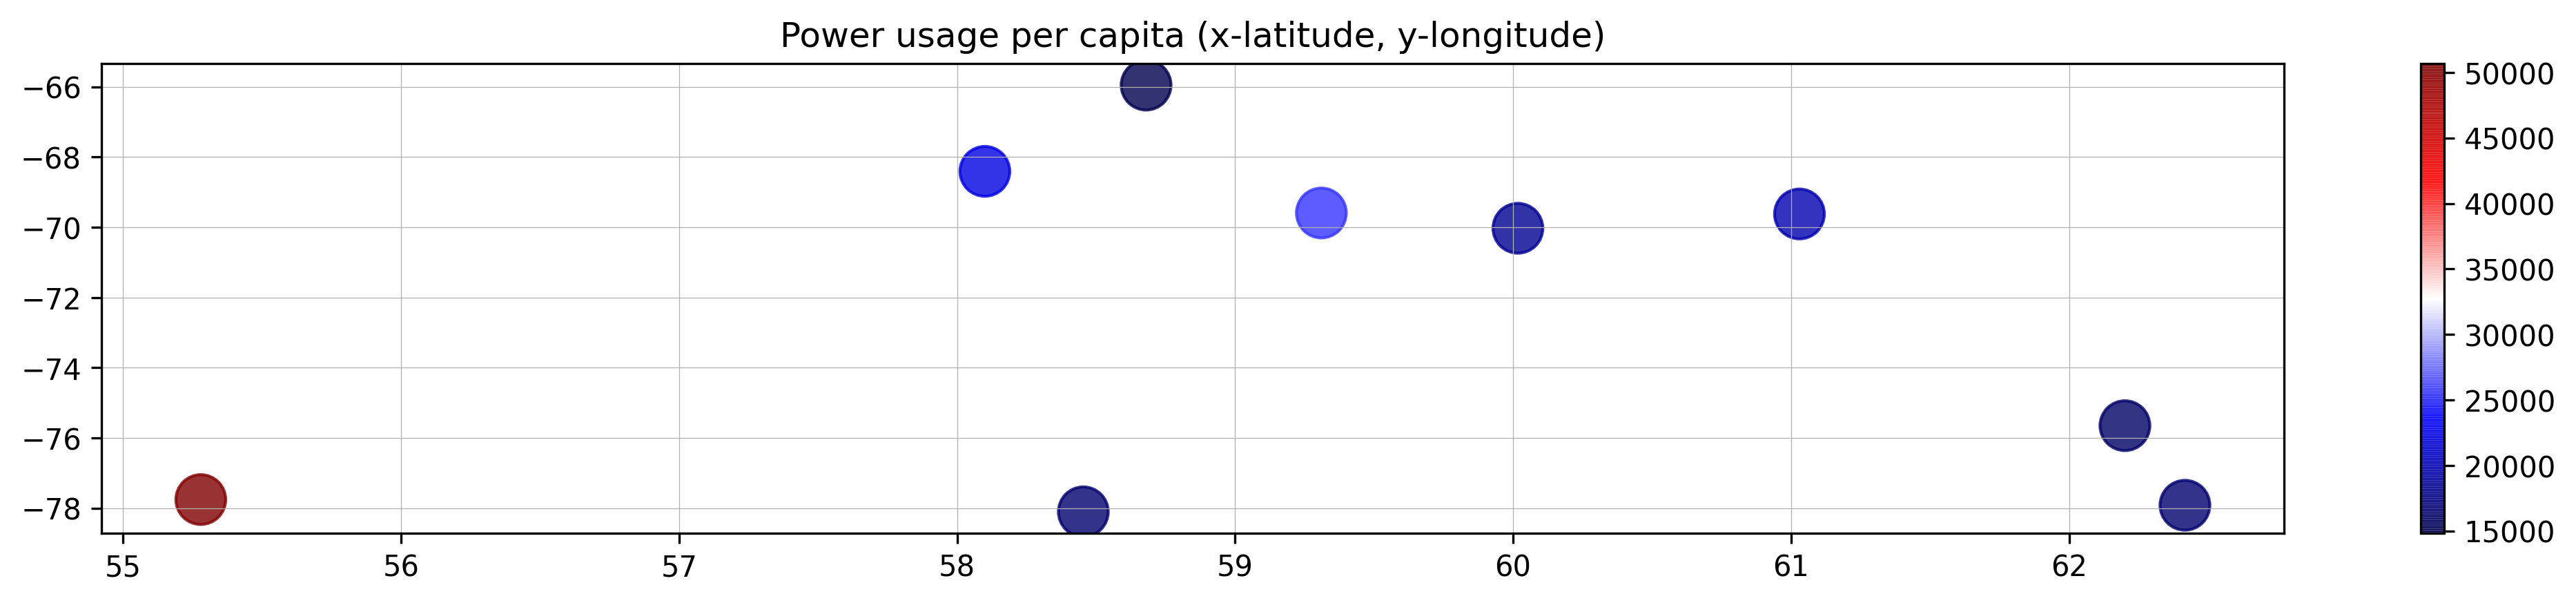

In [97]:
dd=dfc[['lat','lon','Kw_per_capita']].groupby(['lat','lon'])['Kw_per_capita'].sum().reset_index()

# fig, ax = plt.subplots()
plt.rcParams.update({'figure.figsize': (17, 3), 'figure.dpi':300})
plt.scatter(dd.lat, dd.lon, alpha = .8, c = dd.Kw_per_capita, cmap = 'seismic', s=300)
plt.grid(linestyle='-', linewidth=0.3)
plt.title("Power usage per capita (x-latitude, y-longitude)")
cbar = plt.colorbar()

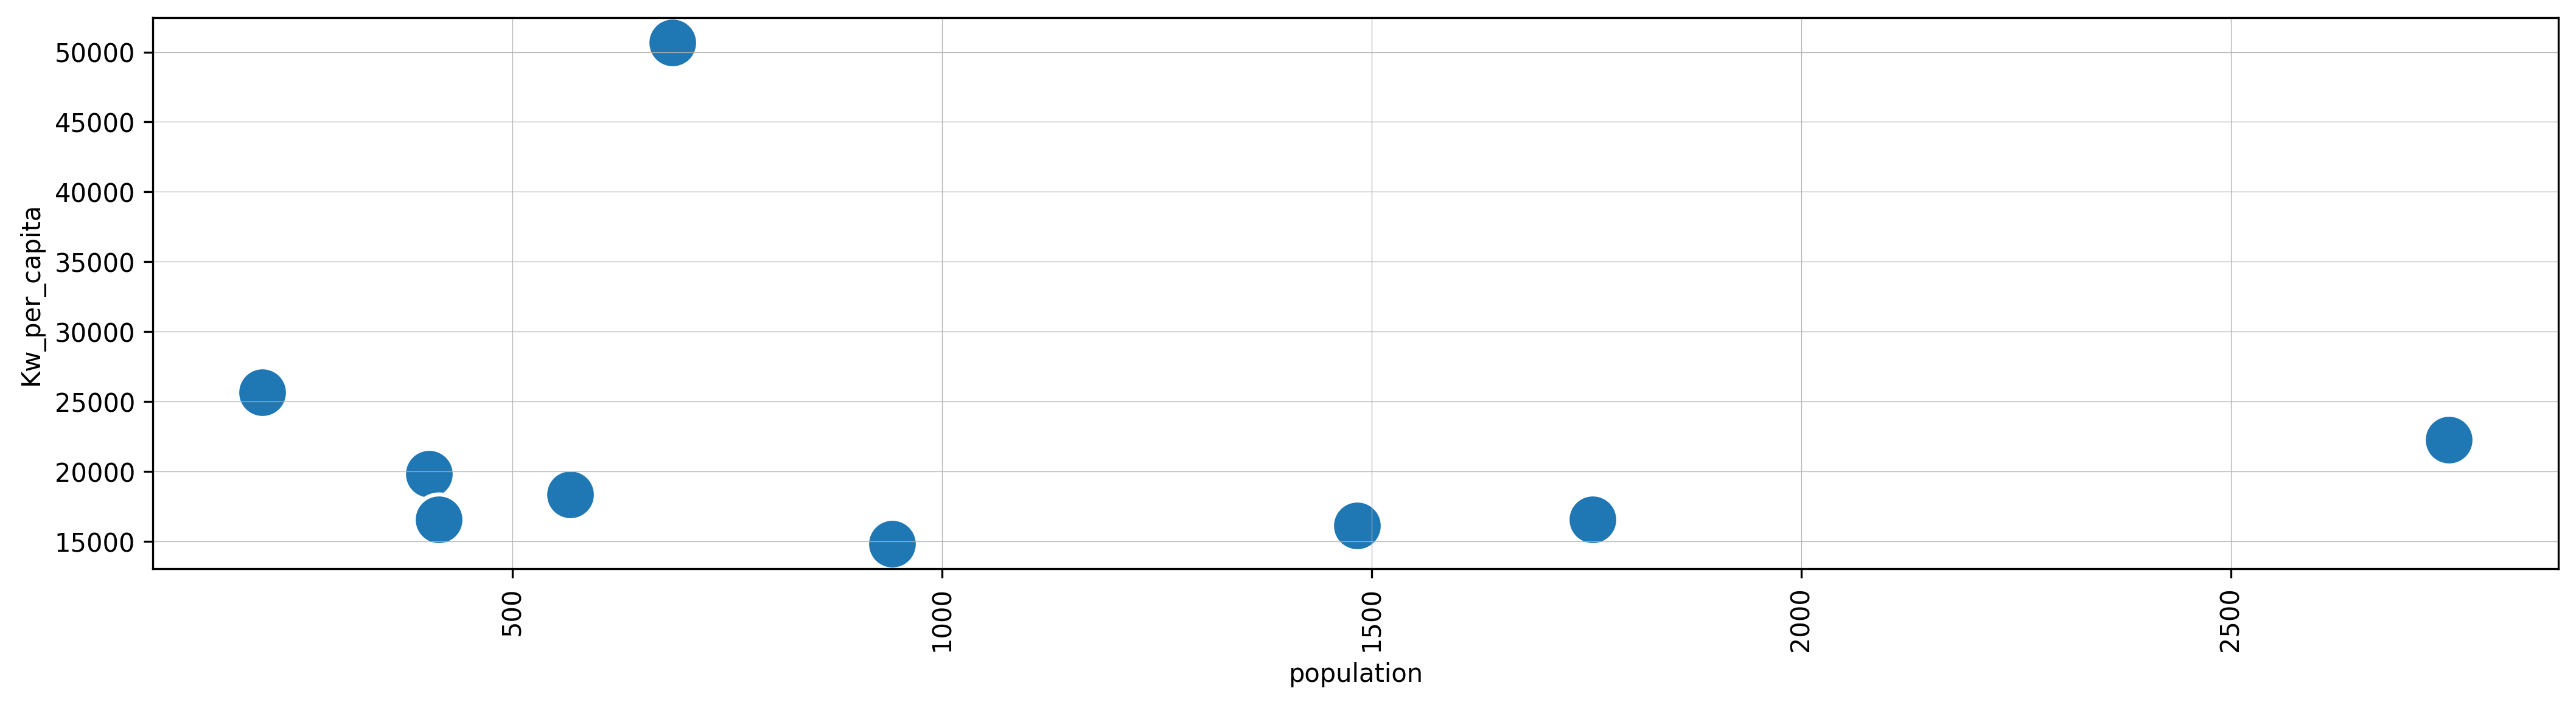

In [98]:
# groupby population, which is equivalent to groupby location (since each location's population is different)
# then sum over all the past time, 
# meaning we are adding up the daily average Kw per cap for the past 3 years of given data
dd=dfc[['population','Kw_per_capita']].groupby(['population']).sum().reset_index()

plt.rcParams.update({'figure.figsize': (17, 4), 'figure.dpi':300})
fig, ax = plt.subplots()
sns.scatterplot(x = "population", y = "Kw_per_capita", data = dd, s=400)
plt.grid(linestyle='-', linewidth=0.3)
ax.tick_params(axis='x', rotation=90)

### Annual_peak_load, population, lat, lon are unique to the community, each community only has one *Annual_peak_load, population, lat, lon*

In [132]:
# dd=dfc
# dd=dd[['annual_peak_load','Kw_per_capita']].groupby(['annual_peak_load'])['Kw_per_capita'].sum().reset_index()

# plt.rcParams.update({'figure.figsize': (17, 5), 'figure.dpi':300})
# fig, ax = plt.subplots()
# sns.scatterplot(x = "annual_peak_load", y = "Kw_per_capita", data = dd, s=200)
# plt.grid(linestyle='-', linewidth=0.3)
# ax.tick_params(axis='x', rotation=90)

## Exploratory data analysis


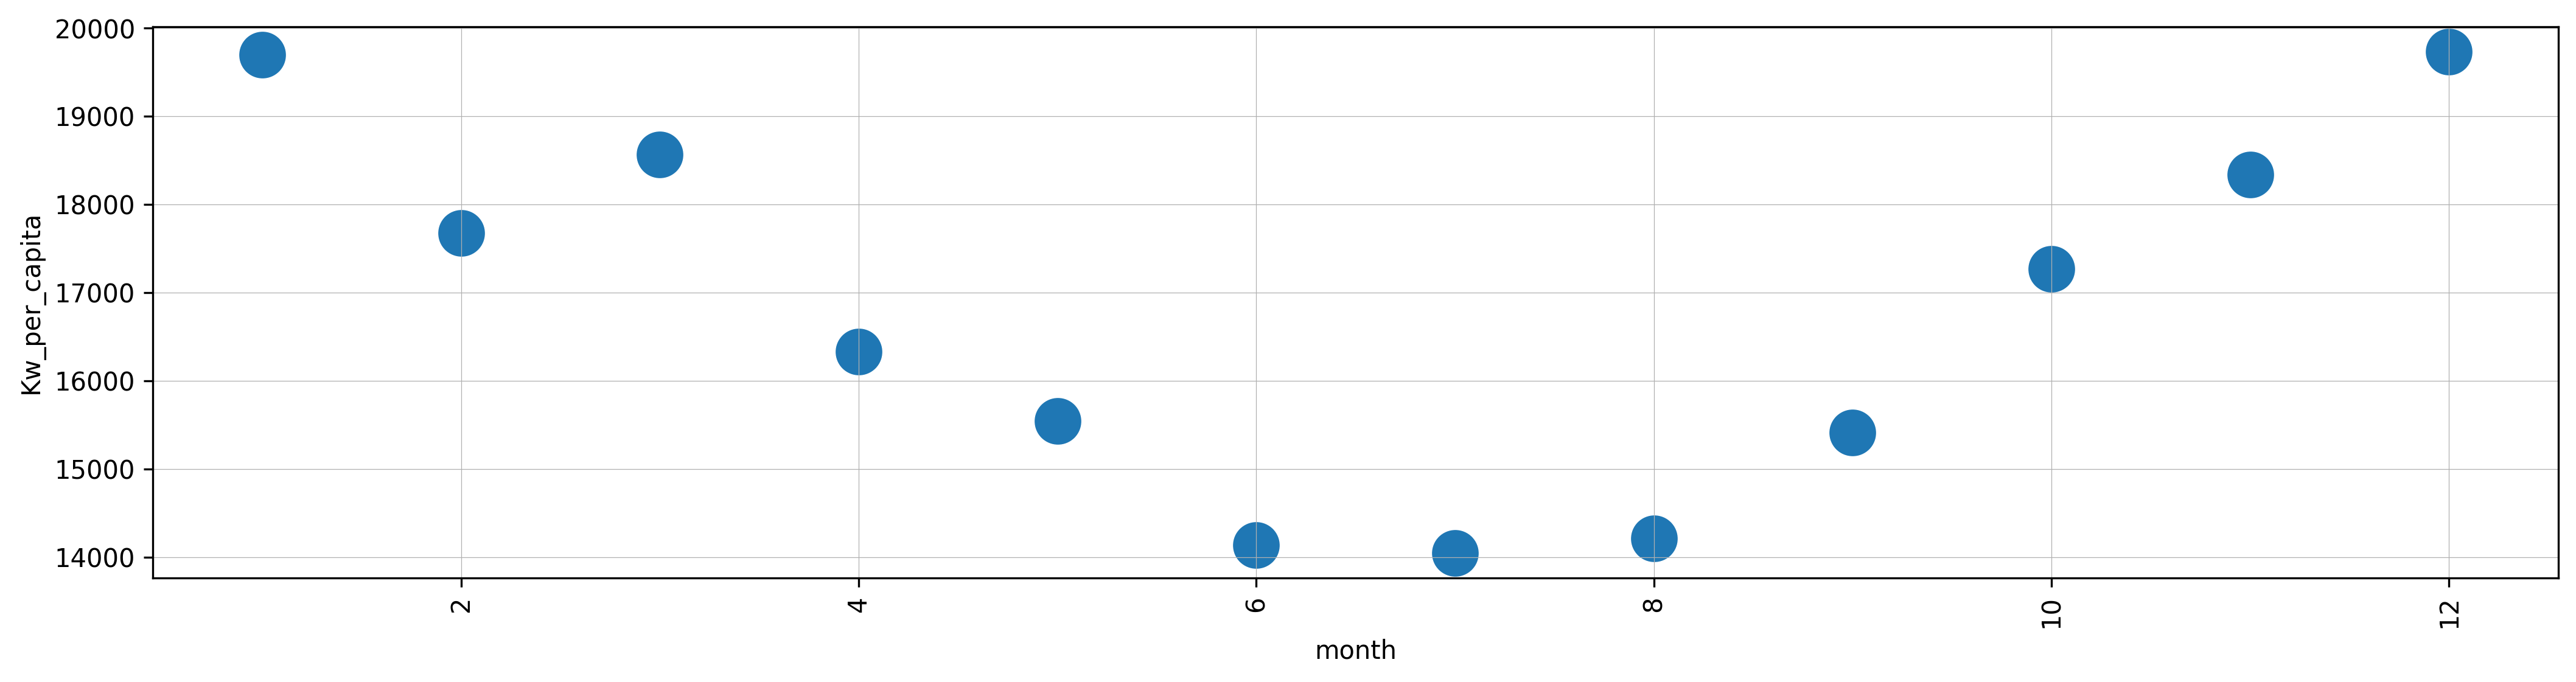

In [100]:
dd=dfc[['month','Kw_per_capita']].groupby(['month'])['Kw_per_capita'].sum().reset_index()

plt.rcParams.update({'figure.figsize': (17, 4), 'figure.dpi':300})
fig, ax = plt.subplots()
sns.scatterplot(x = "month", y = "Kw_per_capita", data = dd, s = 400)
plt.grid(linestyle='-', linewidth=0.3)
ax.tick_params(axis='x', rotation=90)

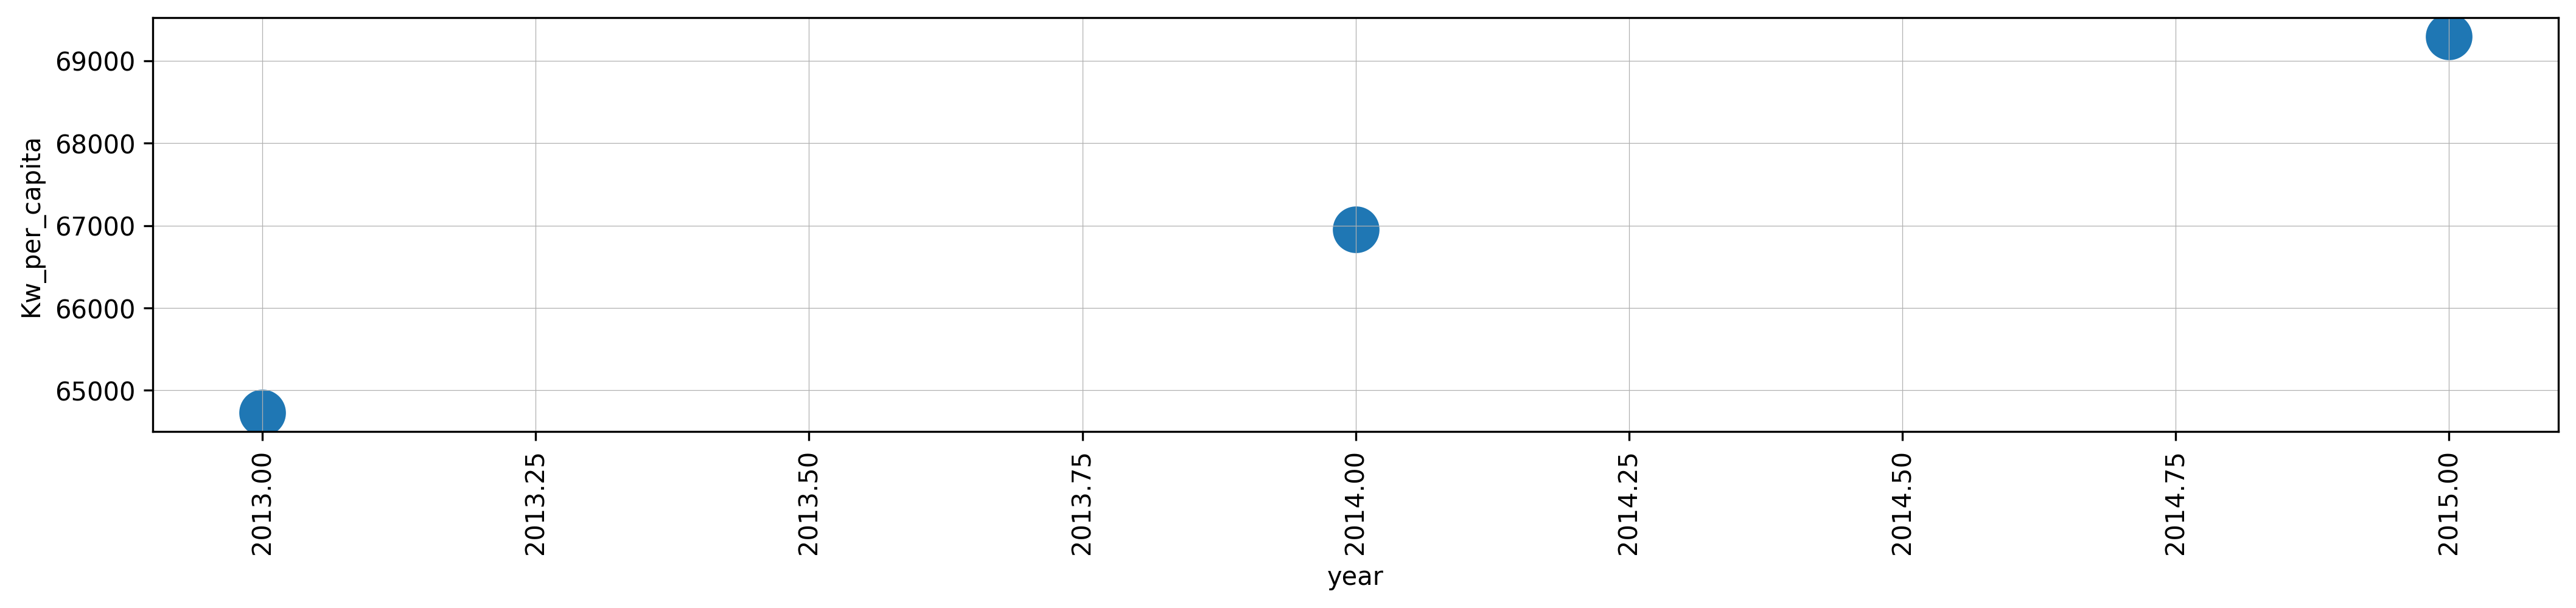

In [101]:
dd=dfc[['year','Kw_per_capita']].groupby(['year'])['Kw_per_capita'].sum().reset_index()

plt.rcParams.update({'figure.figsize': (17, 3), 'figure.dpi':300})
fig, ax = plt.subplots()
sns.scatterplot(x = "year", y = "Kw_per_capita", data = dd, s = 400)
plt.grid(linestyle='-', linewidth=0.3)
ax.tick_params(axis='x', rotation=90)

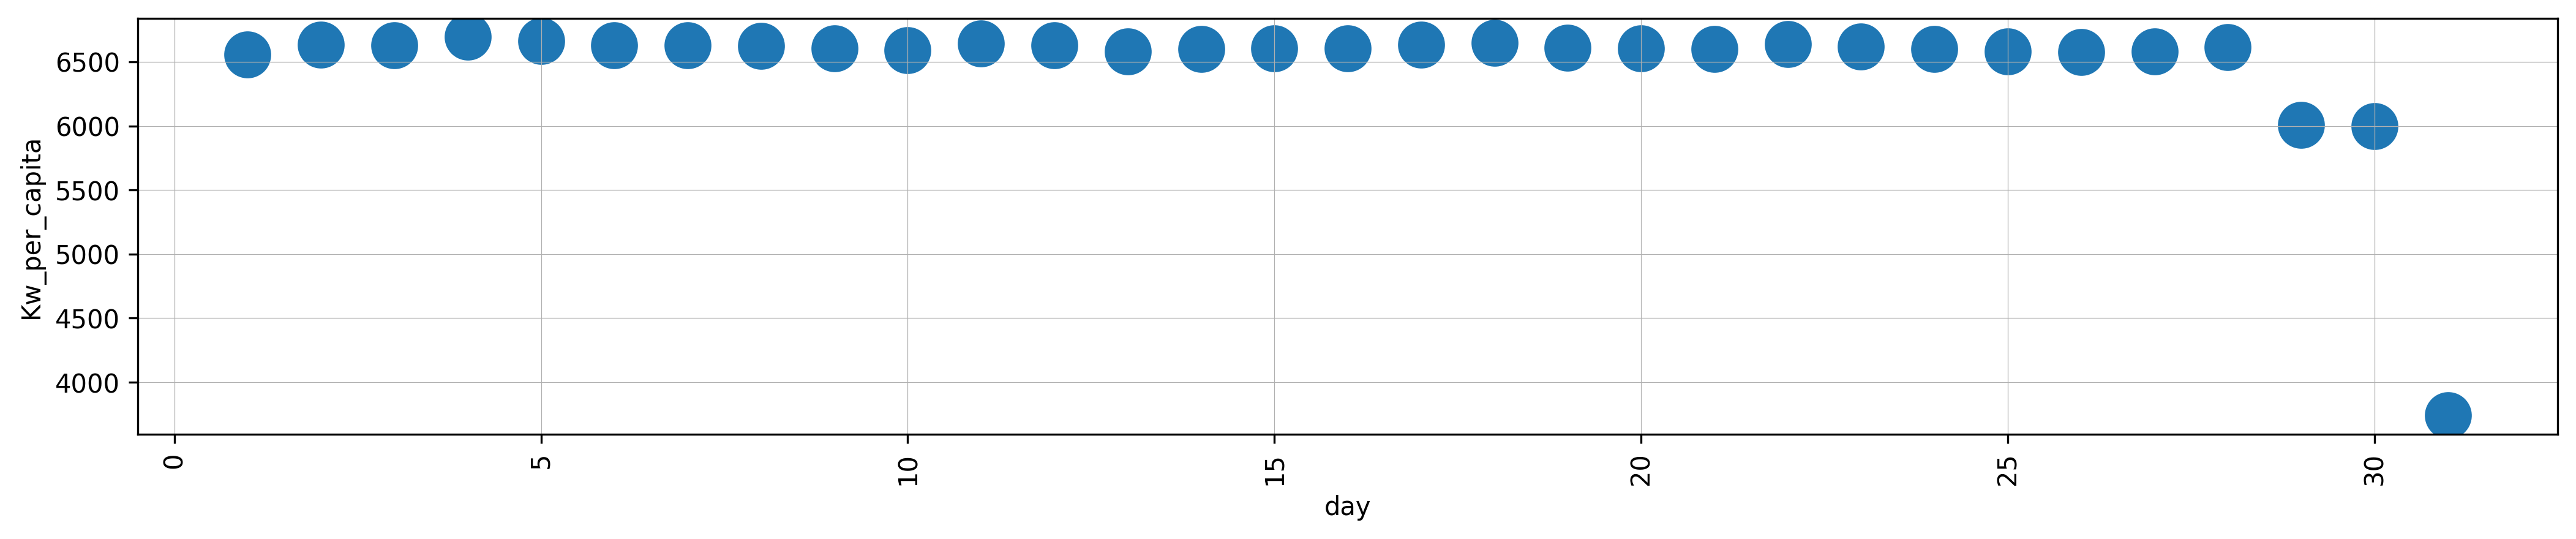

In [102]:
dd=dfc[['day','Kw_per_capita']].groupby(['day'])['Kw_per_capita'].sum().reset_index()

plt.rcParams.update({'figure.figsize': (17, 3), 'figure.dpi':300})
fig, ax = plt.subplots()
sns.scatterplot(x = "day", y = "Kw_per_capita", data = dd, s = 400)
plt.grid(linestyle='-', linewidth=0.3)
ax.tick_params(axis='x', rotation=90)

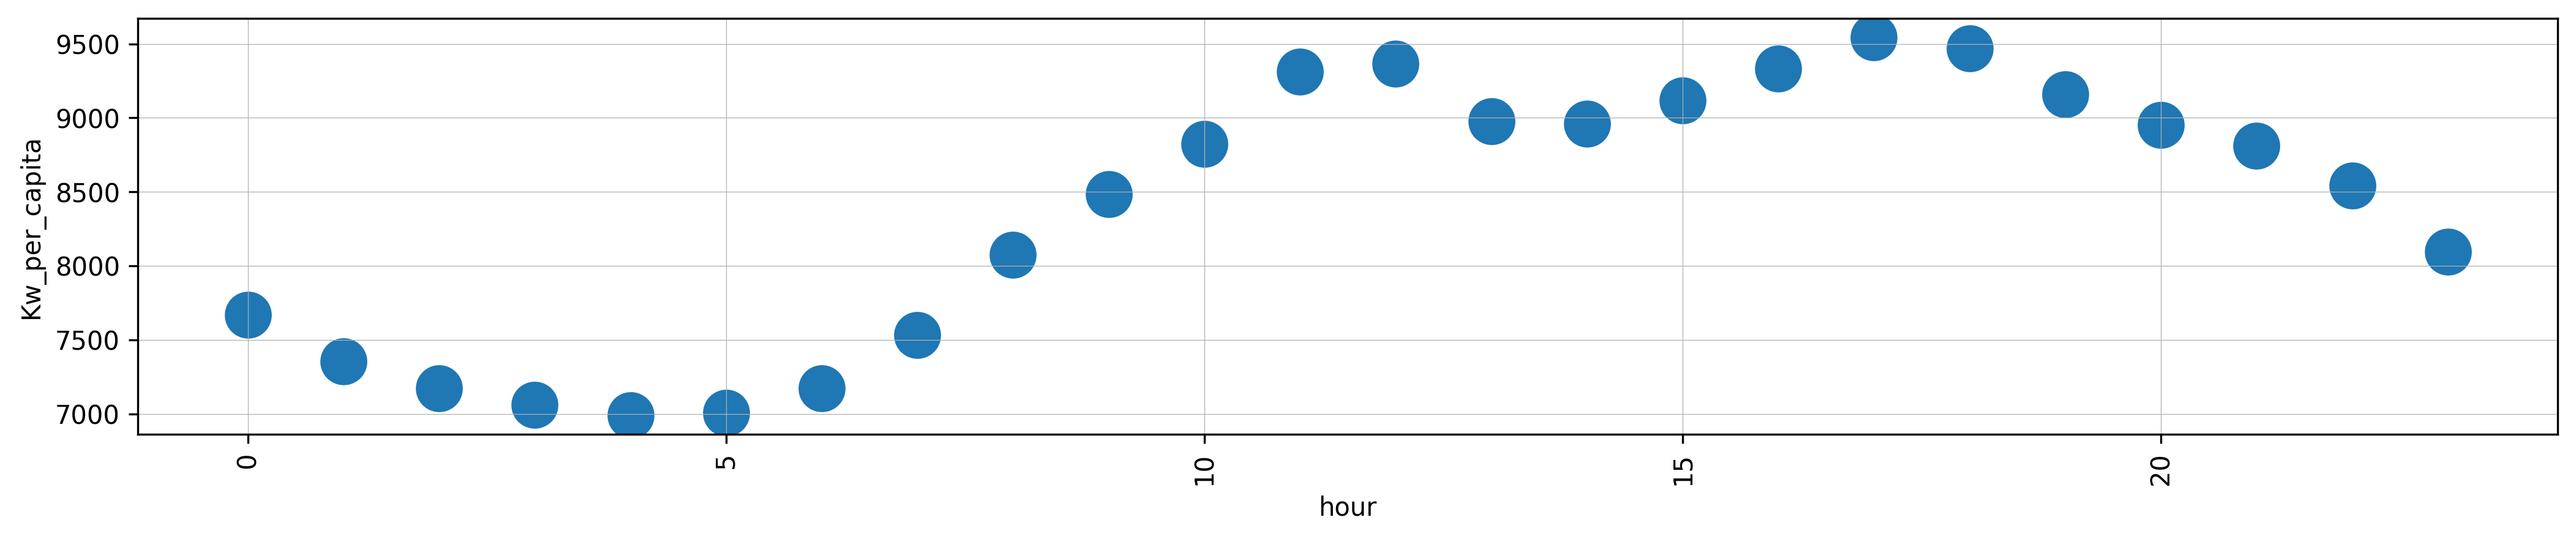

In [103]:
dd=dfc[['hour','Kw_per_capita']].groupby(['hour'])['Kw_per_capita'].sum().reset_index()

plt.rcParams.update({'figure.figsize': (17, 3), 'figure.dpi':300})
fig, ax = plt.subplots()
sns.scatterplot(x = "hour", y = "Kw_per_capita", data = dd, s=400)
plt.grid(linestyle='-', linewidth=0.3)
ax.tick_params(axis='x', rotation=90)

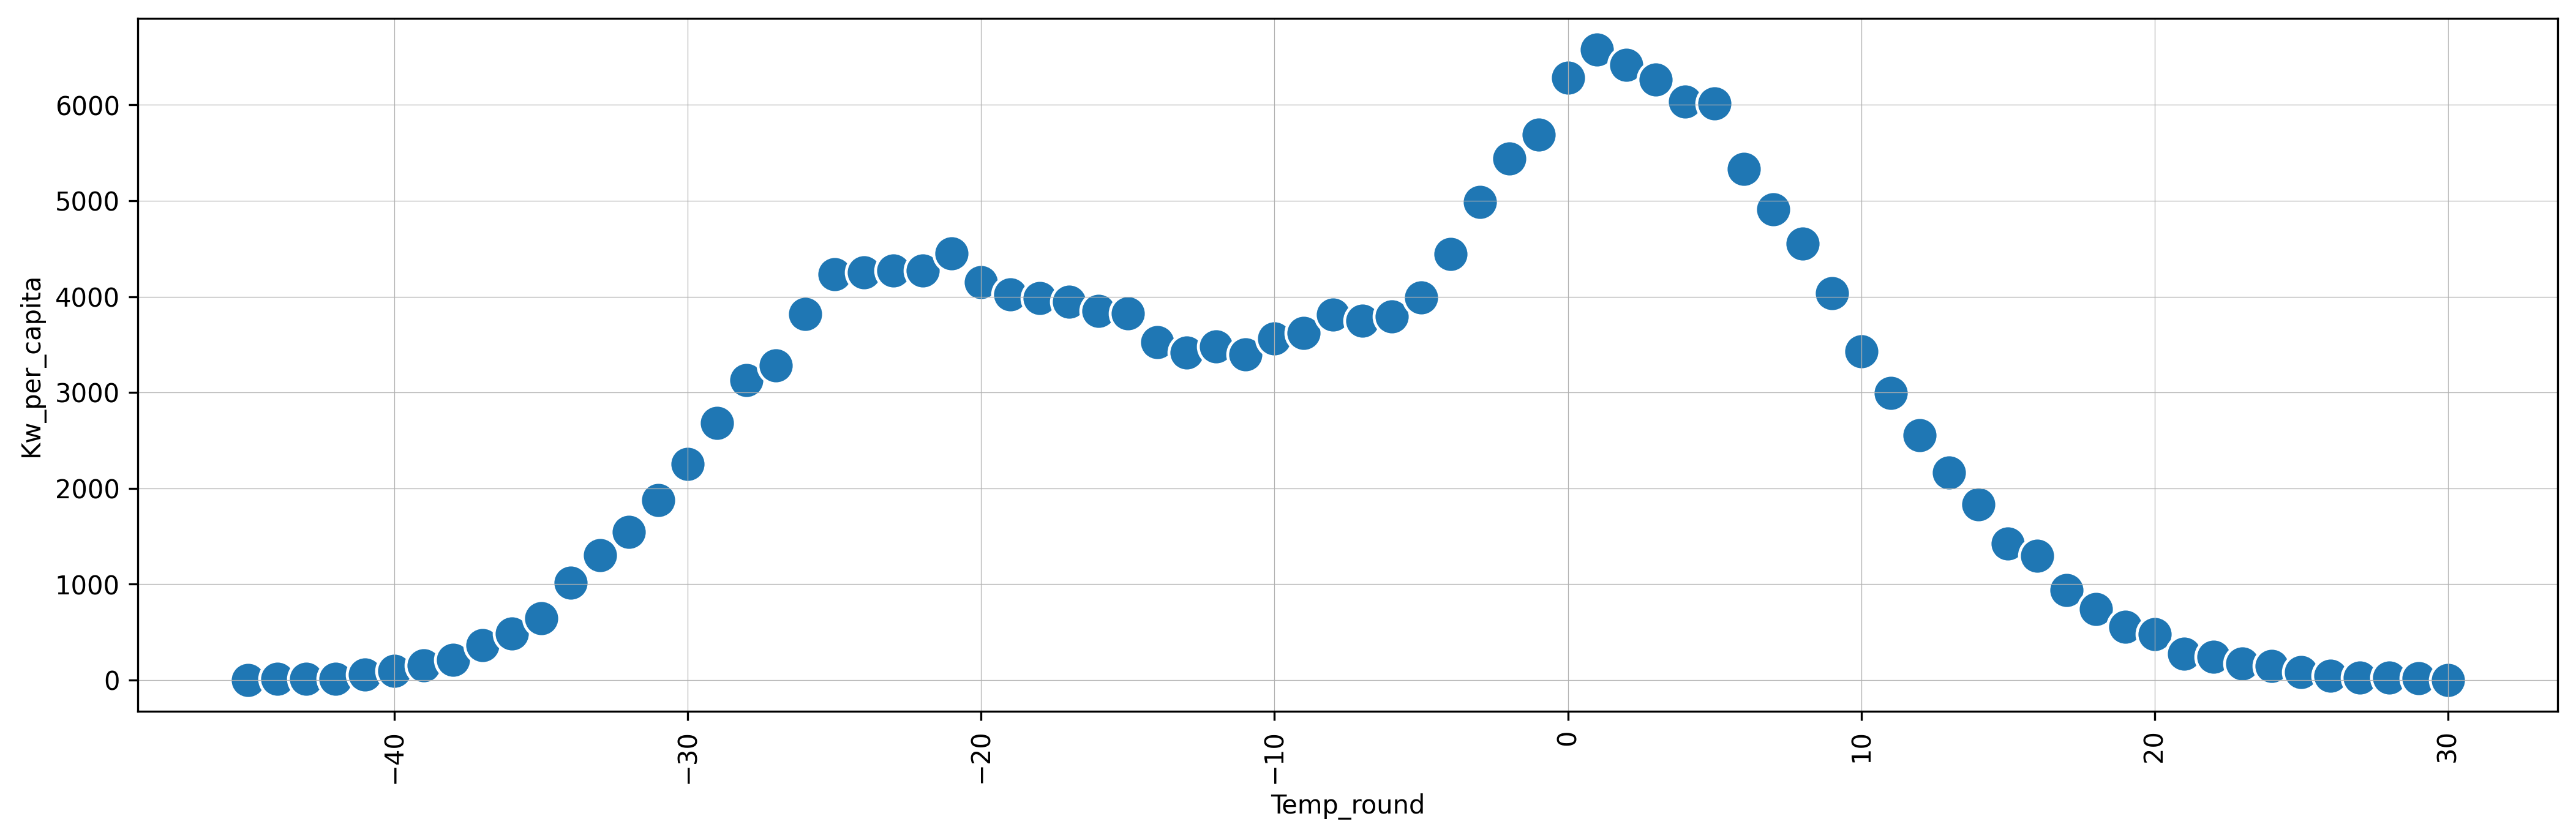

In [104]:
dd=dfc
dd['Temp_round']=dd['Temp'].round()
dd=dd[['Temp_round','Kw_per_capita']].groupby(['Temp_round'])['Kw_per_capita'].sum().reset_index()

plt.rcParams.update({'figure.figsize': (17, 5), 'figure.dpi':300})
fig, ax = plt.subplots()
sns.scatterplot(x = "Temp_round", y = "Kw_per_capita", data = dd, s=200)
plt.grid(linestyle='-', linewidth=0.3)
ax.tick_params(axis='x', rotation=90)

## Reduce data to essential columns
The logic behind is that __['population', 'annual_peak_load', 'hour','lon']__ are __community-specific__, which means we have only 9 different values for each of the 4 variables. That is NOT enough for the algorithm to learn. We might as well replace all of them with a location label, such as __location 1, location 2, etc__

In [105]:
dfcc = dfc.drop(['Kw', 'population', 'annual_peak_load','year','month','day','hour','lon','Temp', 'Temp_round'],
         axis = 1, inplace = False)

In [134]:
dfc.head(3)

,year,month,day,hour,Kw,lat,lon,population,annual_peak_load,Temp,datetime,Kw_per_capita,Temp_round
0,2013,1,1,0,1314.522302,55.27987,-77.75458,686,1984.209328,-16.415625,2013-01-01 00:00:00,1.916213,-16.0
1,2013,1,1,1,1295.379198,55.27987,-77.75458,686,1984.209328,-17.082617,2013-01-01 01:00:00,1.888308,-17.0
2,2013,1,1,2,1281.408115,55.27987,-77.75458,686,1984.209328,-16.936621,2013-01-01 02:00:00,1.867942,-17.0


In [107]:
dfcc.sample(3)

,lat,datetime,Kw_per_capita
146516,62.41657,2014-09-22 20:00:00,0.885266
205833,58.68000,2015-07-01 08:00:00,0.539632
213676,60.01732,2013-05-24 03:00:00,0.571954


## Data by location: creates 9 dataframes df1...df9 to hold info for the 9 locations

In [108]:
# type(dfc['lat'].value_counts())
# dfc['lat'].value_counts().keys()
dfcc['lat'].value_counts()

58.45424    26280
62.20071    26280
61.03000    26280
59.31042    26280
62.41657    26280
58.10006    26280
60.01732    26280
55.27987    26232
58.68000    26232
Name: lat, dtype: int64

In [109]:
# create a list of dataframe names, key=['df1', 'df2', 'df3', 'df4', 'df5', 'df6', 'df7', 'df8', 'df9']
key=[]
for i in range(9):
    key.append('df'+str(i+1))
# print(key)

# create a list of dataframes
s=key.copy()
i=0
for lat in dfcc['lat'].value_counts().keys():
#     print(lat)
    s[i]=dfcc[dfcc['lat']==lat]
#     print(name.head(2))
#     print('\n')
    i=i+1

# create dict using the list of df names and dataframes
for ele in s:
    my_dict = dict.fromkeys(key, ele)

In [110]:
my_dict['df1'].sample(5)

,lat,datetime,Kw_per_capita
192696,58.68,2013-12-30 23:00:00,0.578556
185785,58.68,2013-03-18 00:00:00,0.459041
209734,58.68,2015-12-10 21:00:00,0.701522
197458,58.68,2014-07-17 09:00:00,0.583864
194266,58.68,2014-03-06 09:00:00,0.476115


### Aggregate the data by date, which means sum up all the hourly consumptions

In [111]:
df1=my_dict['df1'].groupby('datetime')['Kw_per_capita'].sum().reset_index()
df1=df1.sort_values(by='datetime')
# df1['date'].value_counts()
df1.head(2)

,datetime,Kw_per_capita
0,2013-01-01 00:00:00,0.536447
1,2013-01-01 01:00:00,0.545294


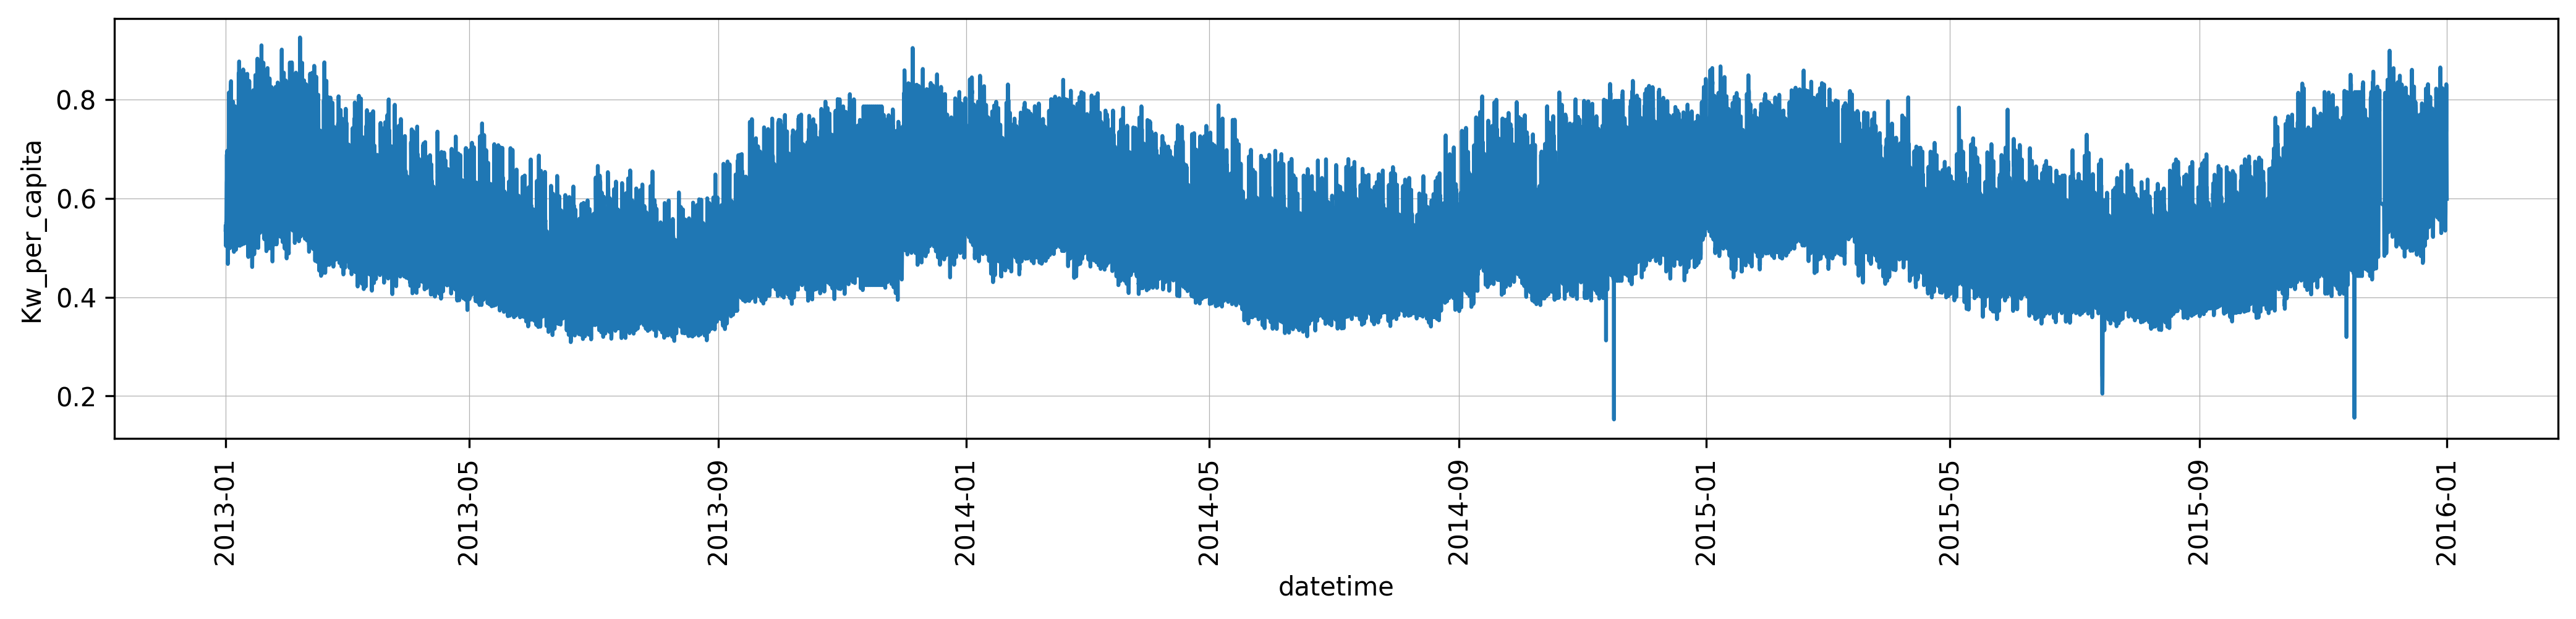

In [112]:
# plot time series
plt.rcParams.update({'figure.figsize': (17, 3), 'figure.dpi':300})
fig, ax = plt.subplots()
sns.lineplot(data=df1, x='datetime', y='Kw_per_capita')
plt.grid(linestyle='-', linewidth=0.3)
ax.tick_params(axis='x', rotation=90)
# dfc.keys()

In [113]:
# see if there are any missing values
df1.isna().sum()

datetime         0
Kw_per_capita    0
dtype: int64

## Correlation plot

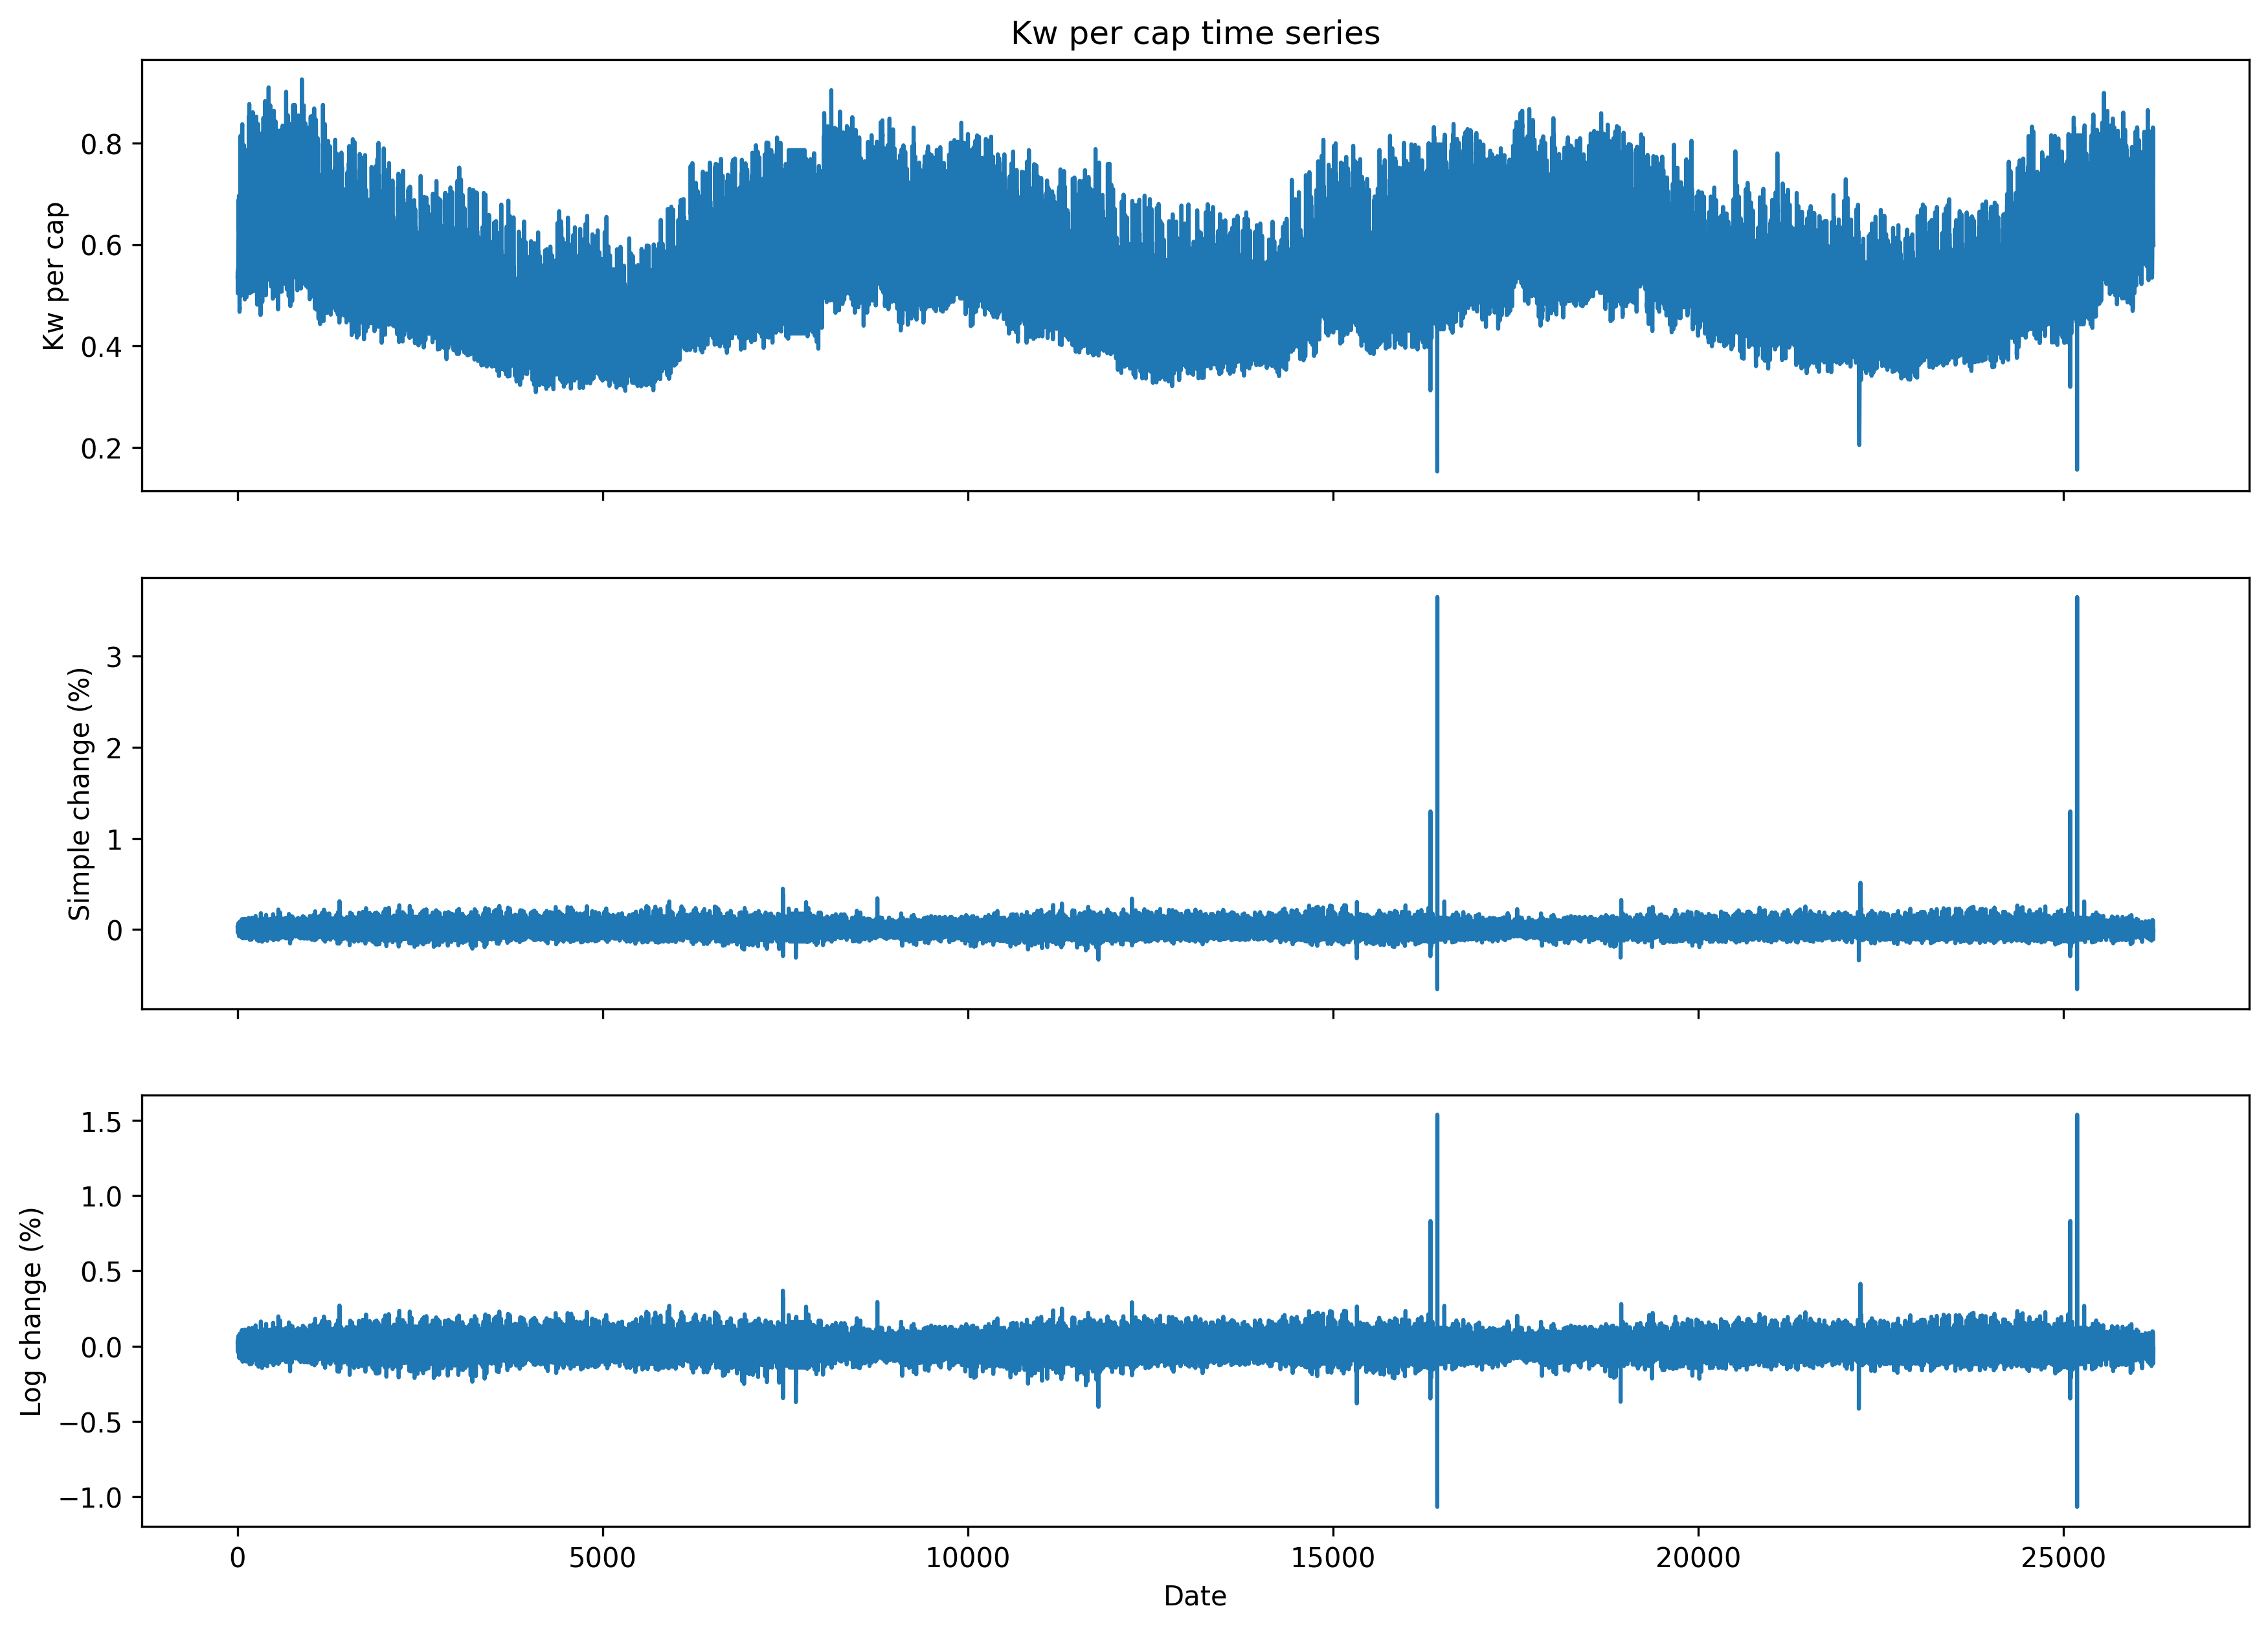

In [135]:
d_series = df1['Kw_per_capita']

# Percentage change between the current and a prior element.
# Computes the percentage change from the immediately previous row by default. 
df1['change'] = d_series.pct_change()
df1['log_change'] = np.log(d_series/d_series.shift(1))
fig, ax = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

d_series.plot(ax=ax[0])
ax[0].set(title = 'Kw per cap time series', ylabel = 'Kw per cap')

df1.simple_rtn.plot(ax=ax[1])
ax[1].set(ylabel = 'Simple change (%)')

df1.log_rtn.plot(ax=ax[2])
ax[2].set(xlabel = 'Date', ylabel = 'Log change (%)')
plt.show()

`df1['change']` is a pandas __Series__, `df1[['change']]` is a __dataframe__

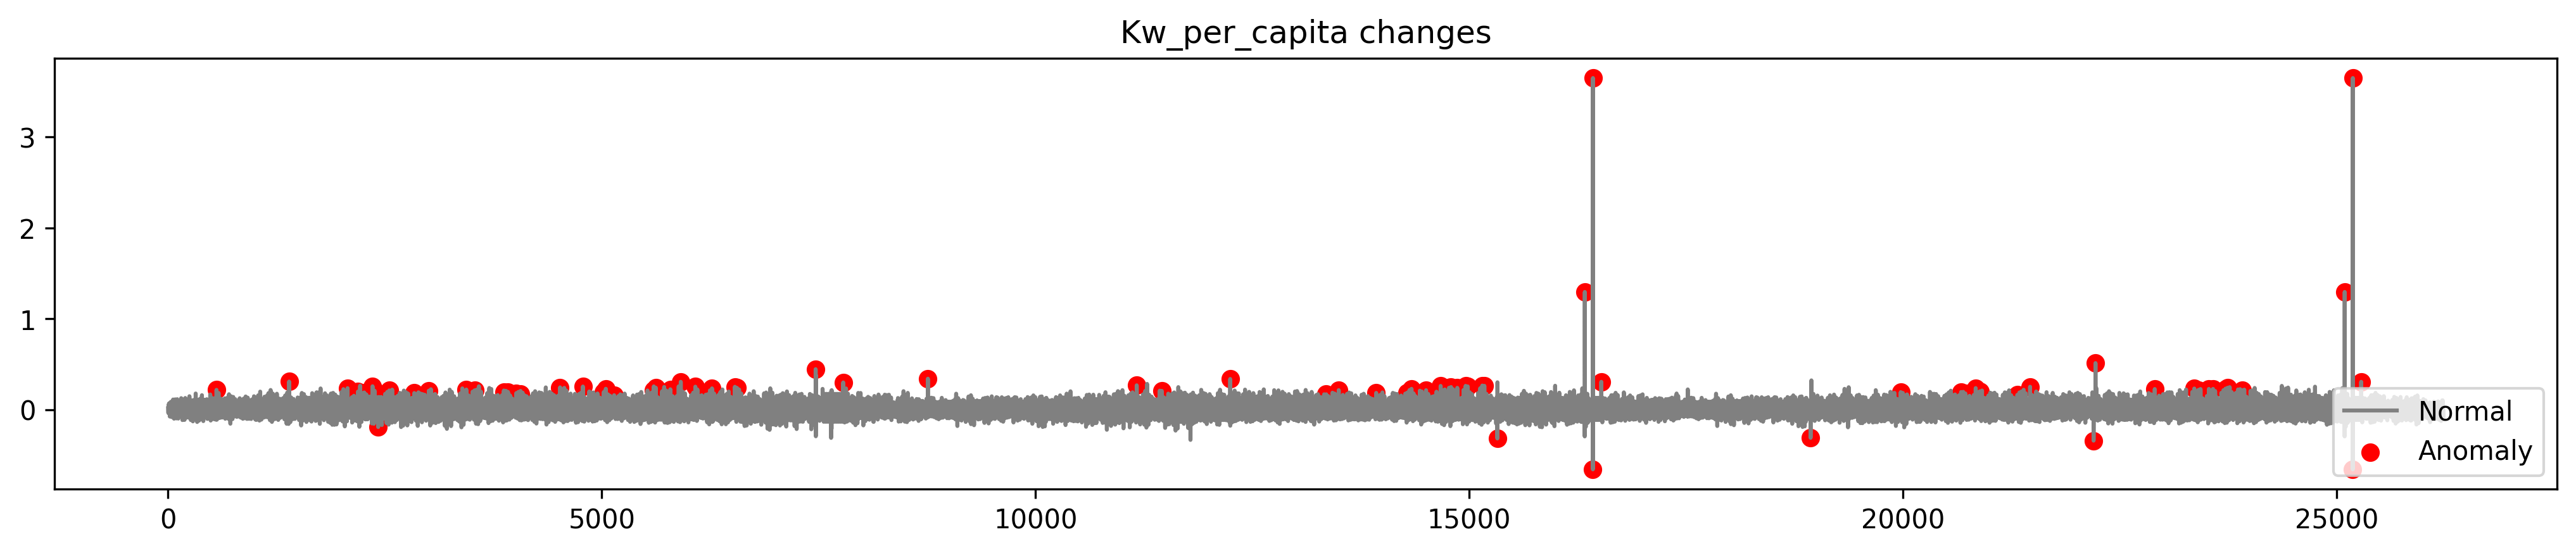

In [137]:
# rolling mean and standard deviation:
df1_rolling = df1[['change']].rolling(window=21).agg(['mean', 'std'])

df1_rolling.columns = df1_rolling.columns.droplevel()

#Join the rolling metrics to the original data:
df1_outliers = df1.join(df1_rolling)

#Define a function for detecting outliers:
def indentify_outliers(row, n_sigmas=3):
    x = row['change']
    mu = row['mean']
    sigma = row['std']
    if (x > mu + 3 * sigma) | (x < mu - 3 * sigma):
        return 1
    else:
        return 0

#Identify the outliers and extract their values for later use
df1_outliers['outlier'] = df1_outliers.apply(indentify_outliers,axis=1)
outliers = df1_outliers.loc[df1_outliers['outlier'] == 1,['change']]

#Plot the results:
fig, ax = plt.subplots()
ax.plot(df1_outliers.index, df1_outliers.simple_rtn, color='gray', label='Normal')
ax.scatter(outliers.index, outliers.change, color='red', label='Anomaly')
ax.set_title("Kw_per_capita changes")
ax.legend(loc='lower right')
plt.show()

__The black swan theory, which predicts that anomalous events, such as a stock market crash, is much more likely to occur than would be predicted by the normal distribution. A good example to illustrate the long-tailed nature of data is stock returns. Below shows the QQ-Plot for the daily Kw_per_cap changes.__

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


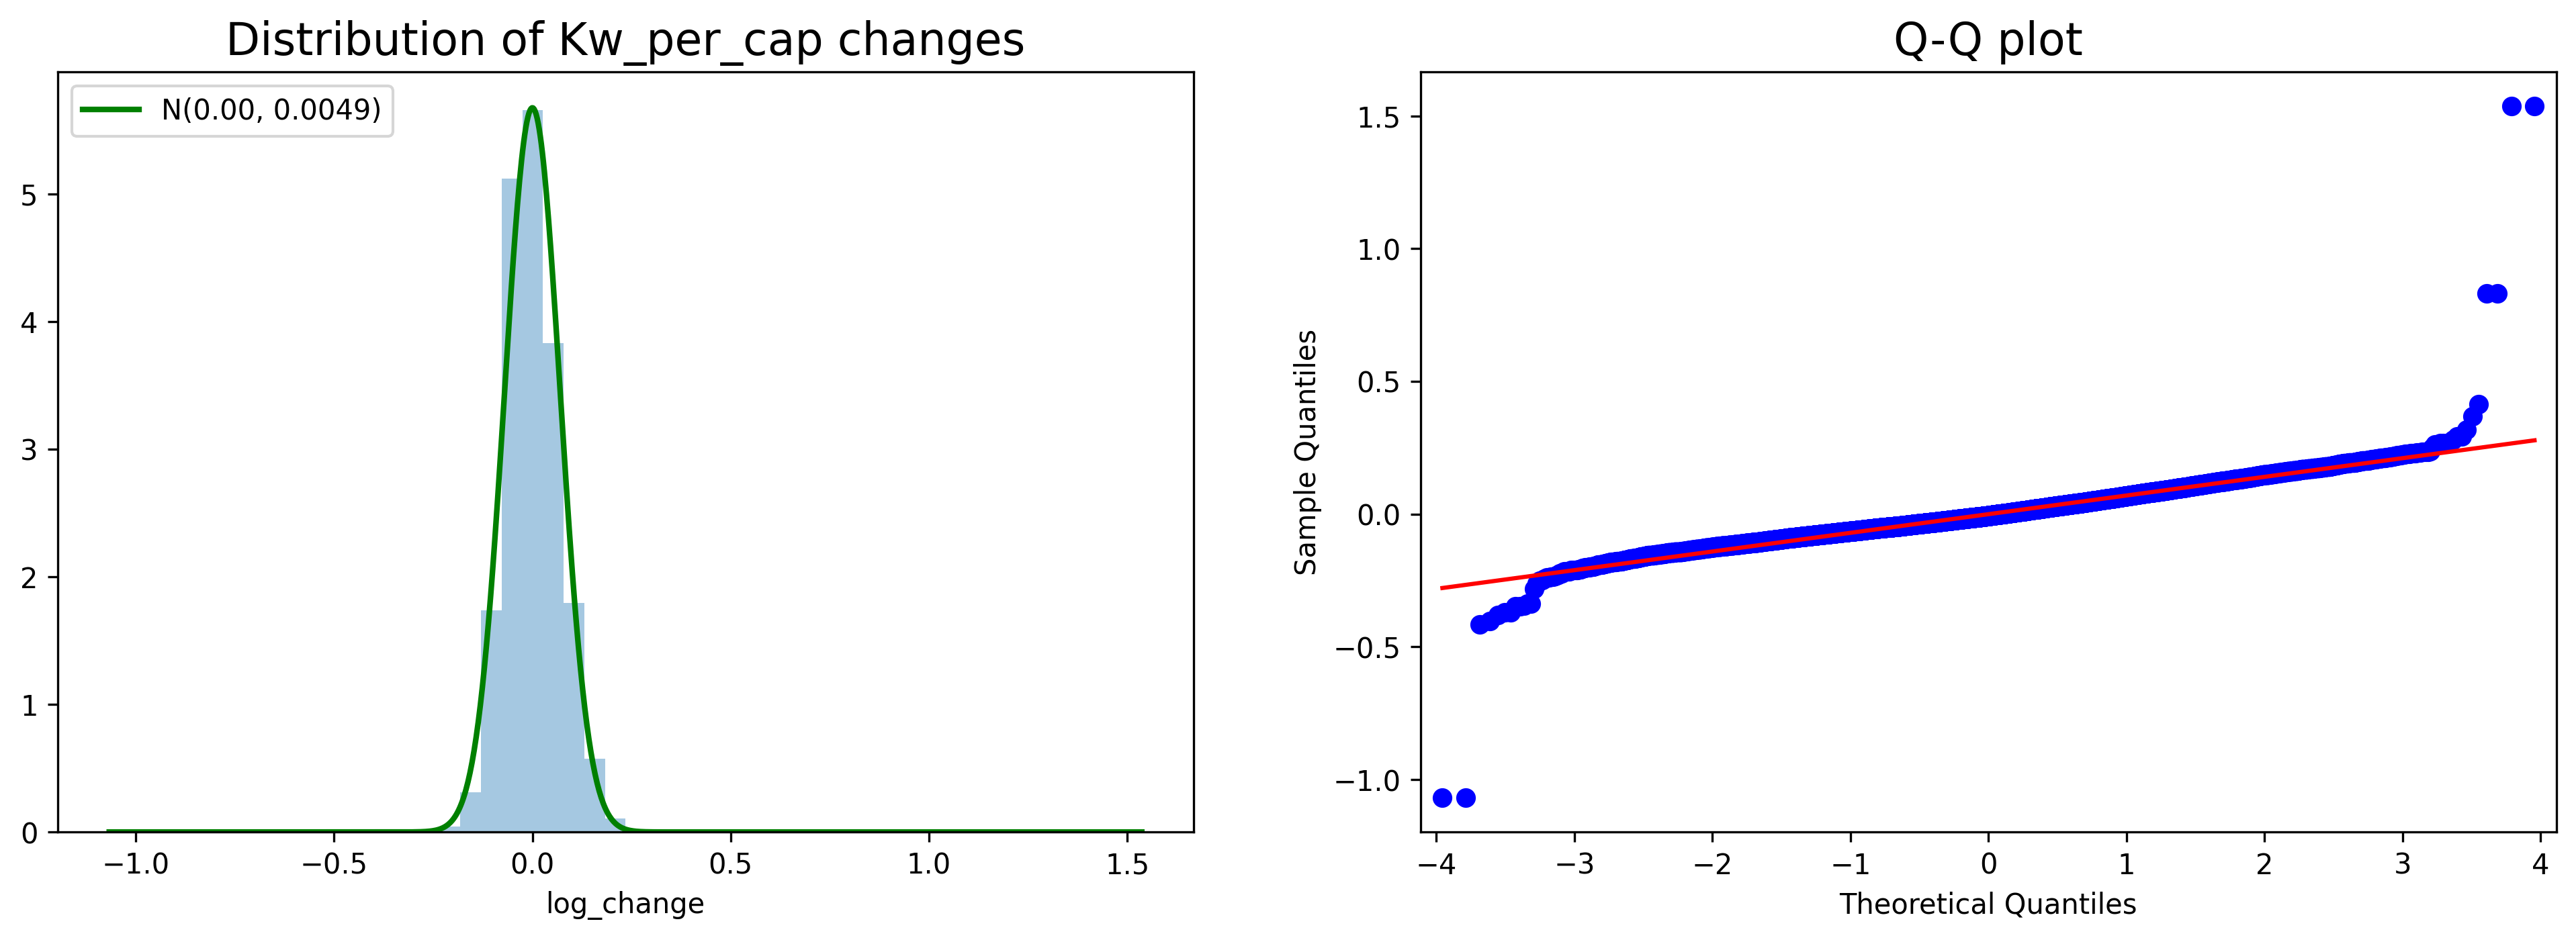

In [138]:
import scipy.stats as scs
r_range = np.linspace(min(df1['log_change'].dropna()), max(df1['log_change'].dropna()), num=1000)
mu = df1['log_change'].dropna().mean()
sigma = df1['log_change'].dropna().std()
norm_pdf = scs.norm.pdf(r_range, loc=mu, scale=sigma)

#Plot the histogram and the Q-Q plot
fig, ax = plt.subplots(1, 2, figsize=(16, 5))

# histogram
sns.distplot(df1['log_change'].dropna(), kde=False, norm_hist=True, ax=ax[0])
ax[0].set_title('Distribution of Kw_per_cap changes', fontsize=16)
ax[0].plot(r_range, norm_pdf, 'g', lw=2, label=f'N({mu:.2f}, {sigma**2:.4f})')
ax[0].legend(loc='upper left');

# Q-Q plot
import statsmodels.api as sm
qq = sm.qqplot(df1['log_change'].dropna().values, line='s', ax=ax[1])
ax[1].set_title('Q-Q plot', fontsize = 16)
plt.show()

__Motivation for modeling volatility by means of nonstationary processes is related to high persistence commonly observed in squared or absolute returns. This shows typical pattern if we draw ACF plots of the squared/absolute returns that are positive and slowly decreasing.__

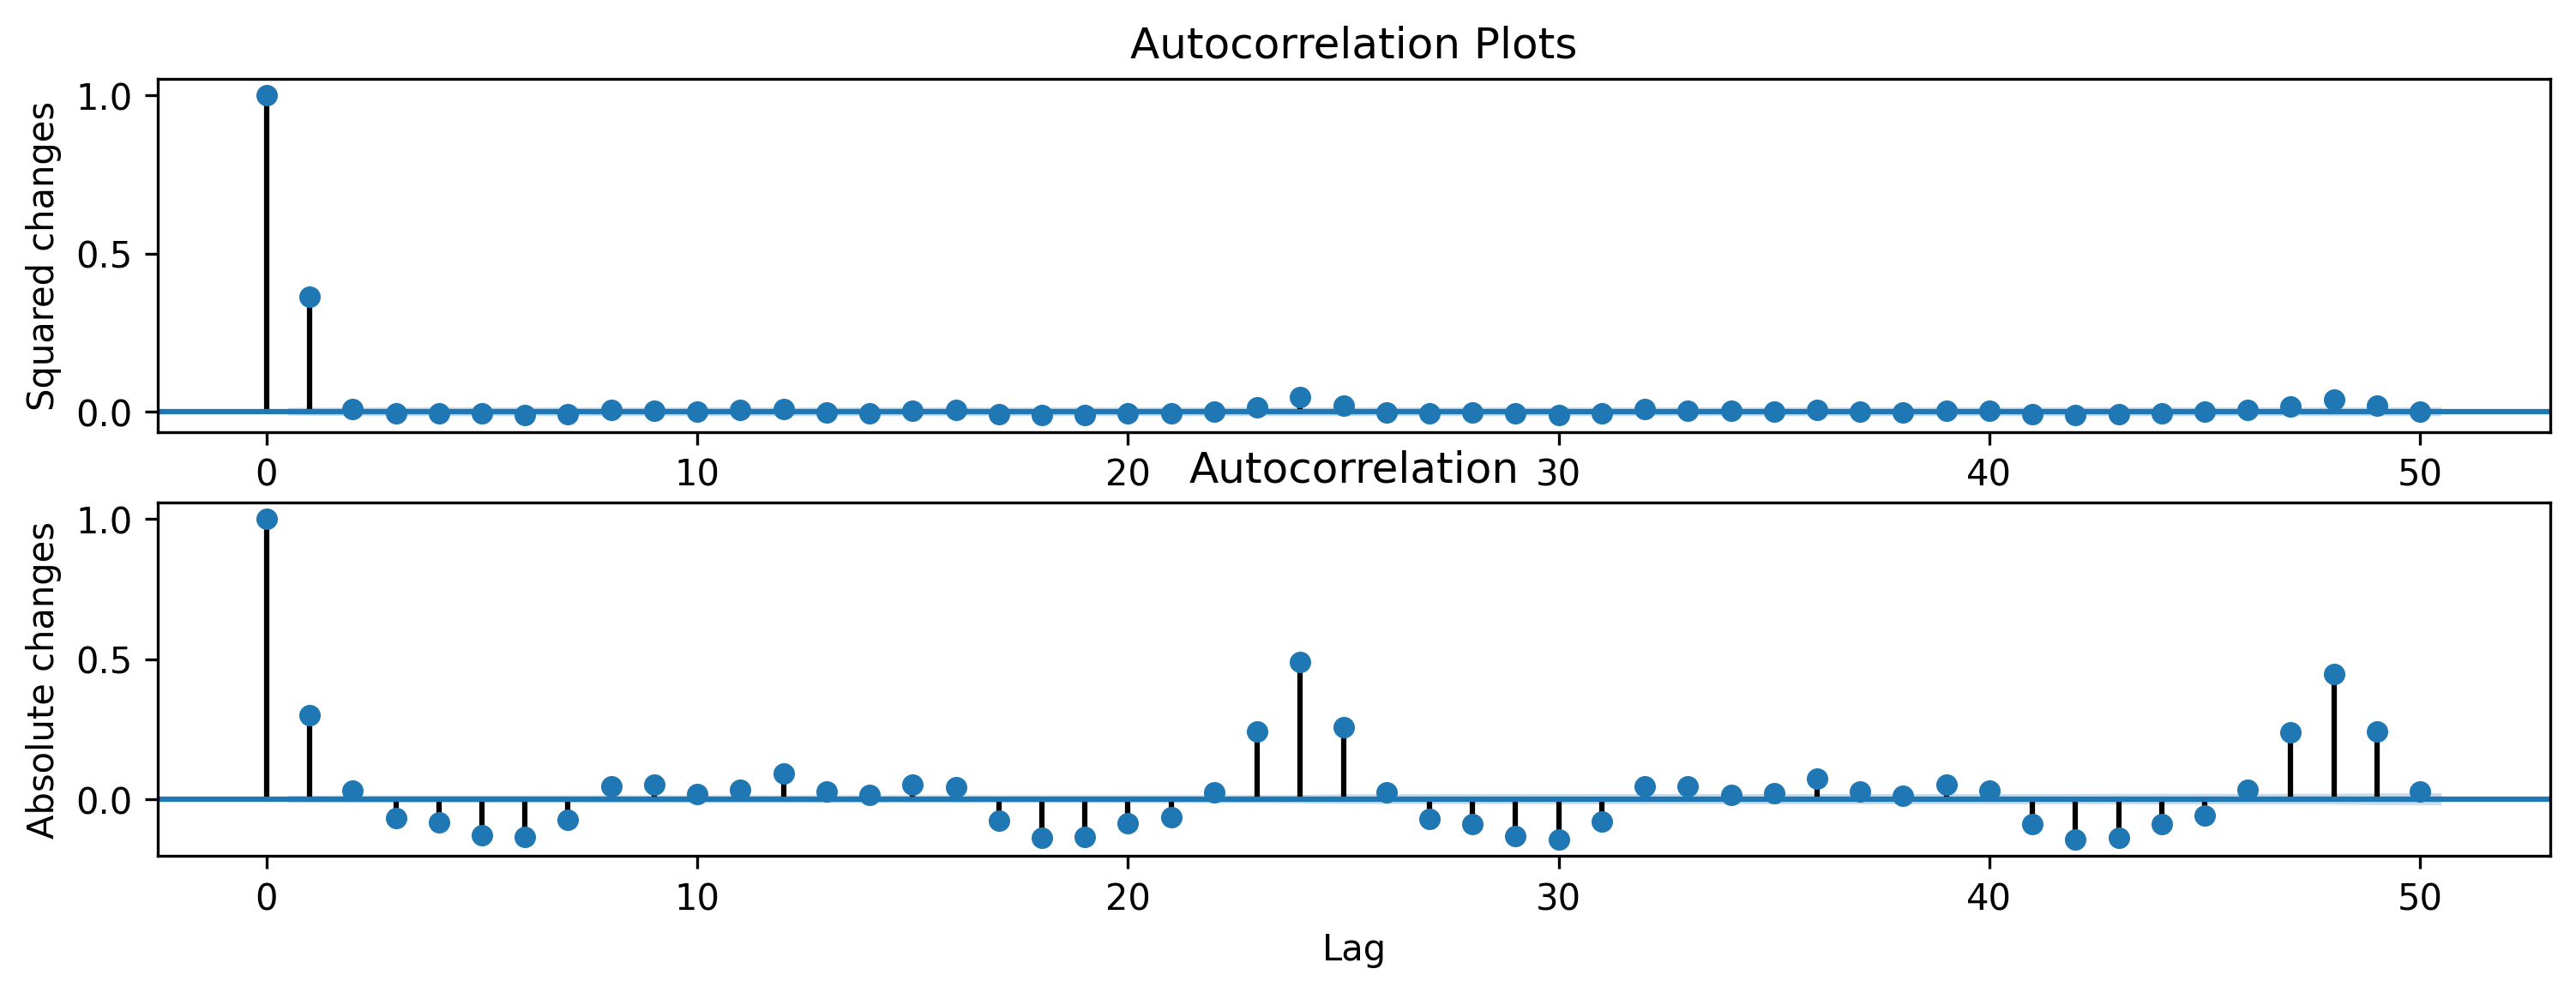

In [139]:
from statsmodels.graphics.tsaplots import plot_acf

N_LAGS = 50; SIGNIFICANCE_LEVEL = 0.05
fig, ax = plt.subplots(2, 1, figsize=(12, 4))

plot_acf(df1['log_change'].dropna() ** 2, lags=N_LAGS,alpha=SIGNIFICANCE_LEVEL, ax = ax[0])
ax[0].set(title='Autocorrelation Plots', ylabel='Squared changes')
plot_acf(np.abs(df1['log_change'].dropna()), lags=N_LAGS,alpha=SIGNIFICANCE_LEVEL, ax = ax[1])
ax[1].set(ylabel='Absolute changes',xlabel='Lag')
plt.show()

In [119]:
df1.sample(2)

,datetime,Kw_per_capita,simple_rtn,log_rtn
9918,2014-02-18 06:00:00,0.507343,-0.072307,-0.075054
11951,2014-05-13 23:00:00,0.482130,-0.129810,-0.139044


## Feature engineering

In [120]:
def build_training_data(data, history_size = 3, target_size = 1):
    """
    history_size denotes the number of columns used as history. For e.g. we use the past 3 days as history, 
    this means we create 3 columns (yesterday, yesterday -1, yesterday -2) as the feature columns. 
    
    target_size denotes the number of columns we want to predict. If we want to predict the following 2 days, 
    this creates 2 columns (tomorrow, tomorrow+1) as the label/target columns
    
    data has to be a dataframe, whose columns time series.
    """
    start_row = history_size
    end_row = len(data) - target_size
    cols2keep = []
    
    # create the input data columns
    cols = range(1, history_size+1)
    for col in cols:
        data[str(col)+'d_prior']=data['Kw_per_capita'].shift(col, axis=0)
        cols2keep.append(str(col)+'d_prior')
        
    # create the label columns
    label_cols = range(1, target_size+1)
    for col in label_cols:
        data['label_'+str(col)]=data['Kw_per_capita'].shift(1-col, axis=0)
        cols2keep.append('label_'+str(col))
        
    # drop the rows that are useless
    rows2drop = [*range(history_size)] + [*range(len(data)-target_size+1, len(data))]
    data.drop(df.index[rows2drop], axis=0, inplace=True)
    # slice dataframe by columns
    data = data.loc[:, cols2keep]
    return data
    
data = df1.copy()        
data = build_training_data(data)

## Train-test split
**Problems:**
- ***we CAN't randomly split a time series with train_test_split(), because the split will randomly select points of time that appear in our train/test data set, which means the time is not continuous, or create gaps in time, this will disrupt the potential correlation exists in a time series.***
- the best to way to train-test split a time series is just take the early 80% as the train data, the following 20% as test data

In [121]:
# alternative train-test split 
# train_dataset, test_dataset = train_test_split(dfc, test_size=0.2)
train_data = data[:int(data.shape[0]*0.8)]
test_data = data[int(data.shape[0]*0.8):]

In [122]:
train_data.sample(2)
# test_data.sample(2)

,1d_prior,2d_prior,3d_prior,label_1
11902,0.564579,0.608015,0.568914,0.527689
14273,0.553432,0.526362,0.537155,0.575460


In [123]:
output_cols=[]
for i in data.columns:
    if 'label' in i:
        output_cols.append(i)

# input_cols=[]
# for i in data.columns:
#     if 'prior' in i:
#         input_cols.append(i)

In [124]:
X_train = train_data.copy().drop(columns=output_cols)
X_test = test_data.copy().drop(columns=output_cols)

y_train = train_data.copy()[output_cols]
y_test = test_data.copy()[output_cols]

In [125]:
# X_train.sample(3)
y_train.sample(3)

,label_1
8878,0.713818
13572,0.533174
12658,0.569533


## Prediction

In [126]:
xgb_r = xgb.XGBRegressor(objective ='reg:squarederror',
                  n_estimators = 10, seed = 123)
  
xgb_r.fit(X_train, y_train)
xgb_r.fit(X_train, 
          y_train, 
         eval_set=[(X_train, y_train),(X_test, y_test)],
         eval_metric='mae')
  


[0]	validation_0-mae:0.10033	validation_1-mae:0.094271
[1]	validation_0-mae:0.091359	validation_1-mae:0.085865
[2]	validation_0-mae:0.083375	validation_1-mae:0.078419
[3]	validation_0-mae:0.076266	validation_1-mae:0.071808
[4]	validation_0-mae:0.069966	validation_1-mae:0.065901
[5]	validation_0-mae:0.064358	validation_1-mae:0.060606
[6]	validation_0-mae:0.059357	validation_1-mae:0.05615
[7]	validation_0-mae:0.054883	validation_1-mae:0.052035
[8]	validation_0-mae:0.050958	validation_1-mae:0.048459
[9]	validation_0-mae:0.047475	validation_1-mae:0.04528


XGBRegressor(n_estimators=10, objective='reg:squarederror', seed=123)

In [127]:
# Predictions on the train dataset
train_pred = xgb_r.predict(X_train)
# RMSE Computation
train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
print("RMSE : % f" %(train_rmse))

RMSE :  0.059432


In [128]:
# Predictions on the train dataset
test_pred = xgb_r.predict(X_test)
# RMSE Computation
test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
print("RMSE : % f" %(test_rmse))

RMSE :  0.057116


### For RMSE, the value of the difference **Abs(y_test - test_pred)** plays a role, 
- if **|y_test-test_pred|<1**, then the RMSE is going to be small, regardless of whether it's a good prediction or not.
- to solve this, we use the Mean Absolute Percentage Error for the relative error.

In [129]:
# define the MAPE metric
def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) 

In [130]:
err_tr = mean_absolute_percentage_error(y_train,train_pred)
print("train MAPE : % f" %(err_tr))

err_tst = mean_absolute_percentage_error(y_test,test_pred)
print("test MAPE : % f" %(err_tst))

train MAPE :  0.204693
test MAPE :  0.208865


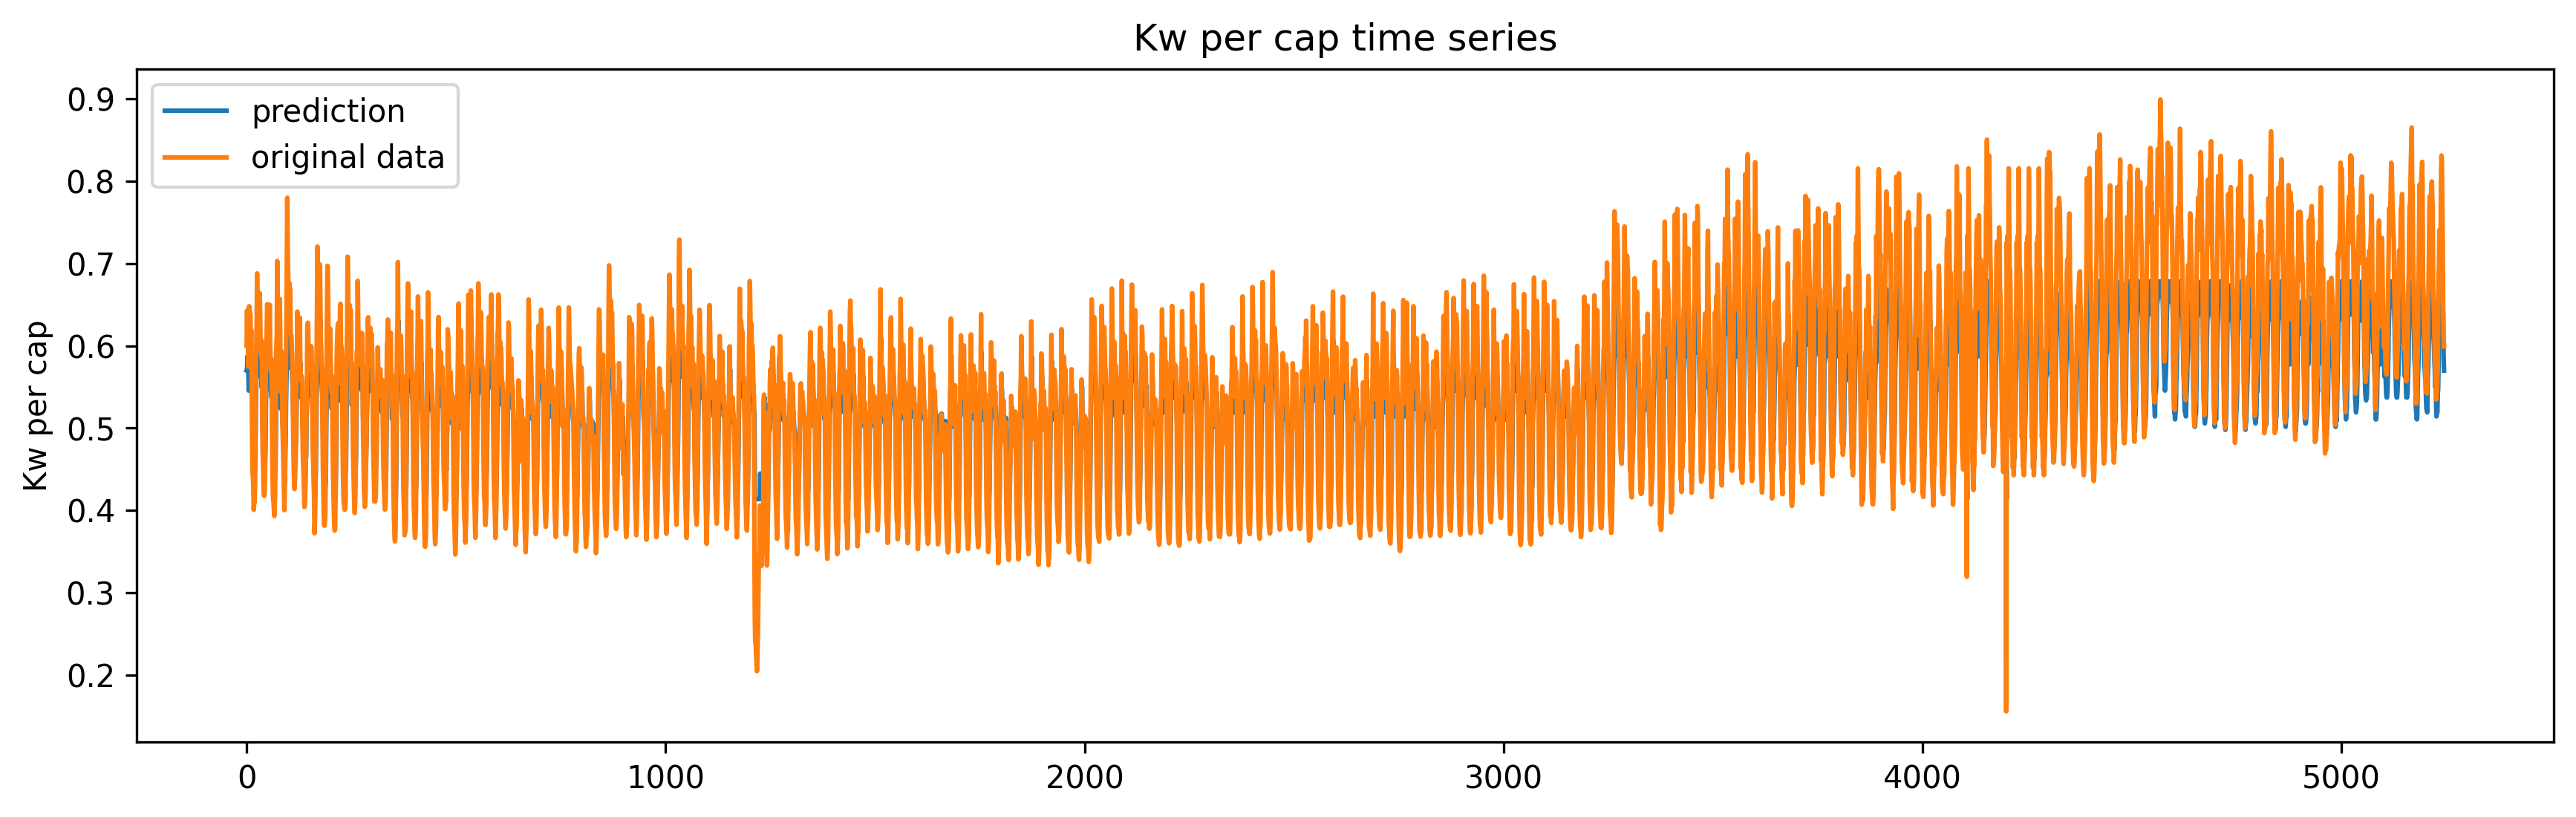

In [131]:
test_series = pd.Series(test_pred)
orig_series = pd.Series(test_data['label_1']).reset_index().drop(columns=['index'])['label_1']
#                         [int(data.shape[0]*0.8):])
fig, ax = plt.subplots(1, 1, figsize=(14, 4), sharex=True)

test_series.plot(ax=ax, label='prediction')
orig_series.plot(ax=ax, label='original data')
ax.set(title = 'Kw per cap time series', ylabel = 'Kw per cap')
plt.legend()
plt.show()

- other features
- other error function than RMSE